In [ ]:
# Installation
!pip install pandas matplotlib seaborn openpyxl

In [199]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from datetime import datetime

In [137]:
# Load your Excel data into a DataFrame
excel_file = 'VCinsight_(Msia)_Sanitized.xlsx'  # Replace with the path to your Excel file
df = pd.read_excel(excel_file)

legend = pd.read_excel(excel_file, sheet_name="Legend", header=None)
legend.columns = ['a', 'b']
legend_dict = legend.set_index('a')['b'].to_dict()

#clean up df
df = df.rename(columns=legend_dict) #rename legend to readable
df.replace('-', 0, inplace=True) #replace - to 0
df.fillna(0) #fill up with 0
df['Date of last fund raise'] = pd.to_datetime(df['Date of last fund raise'], errors='coerce')
df['Date of Financial Year End'] = pd.to_datetime(df['Date of Financial Year End'], errors='coerce')
df['Categories'] = df['Categories'].astype(str).apply(lambda x: x.replace("|", ""))


In [138]:
#get list of category
list(set(df['Categories'].str.get_dummies(',').columns))

#Let chat gpt categorize them into 10 big category
#I store it in JSON

# Open the JSON file and load the key
with open('category.json', 'r') as file:
    # Load the contents of the file as JSON
    data = json.load(file)
    df = df.reindex(columns=[*df.columns.tolist(), *data.keys()], fill_value=0)

    for index, row in df.iterrows():
        categories =[i.strip() for i in row['Categories'].split(',') if i.strip()!='']
        for category in categories:#[a,b,c]
            for json_cat, values in data.items(): #technology -> [a,b,c]
                if category in values: # a in [a,b,c]
                    df.loc[index, json_cat] = 1
                    continue #skip if the json_cat is already 1

In [153]:
data.keys()

dict_keys(['Technology', 'Business Services', 'Health & Wellness', 'Media & Entertainment', 'Finance & Fintech', 'Manufacturing & Industry', 'Environment & Sustainability', 'Consumer Goods & Retail', 'Education & EdTech', 'Travel & Hospitality'])

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Name of Startup                       2189 non-null   object        
 1   Incorporation Date                    2189 non-null   int64         
 2   Total Funding Till Date               2140 non-null   float64       
 3   Last Valuation                        285 non-null    float64       
 4   Amt raised during last funding round  285 non-null    float64       
 5   Revenue for latest Financial Year     1542 non-null   float64       
 6   Date of last fund raise               2189 non-null   datetime64[ns]
 7   Date of Financial Year End            2188 non-null   datetime64[ns]
 8   Revenue growth compared to last FY    2189 non-null   float64       
 9   Earnings before Interest and Tax      1678 non-null   float64       
 10  

In [92]:
df.columns

Index(['Name of Startup', 'Incorporation Date', 'Total Funding Till Date',
       'Last Valuation', 'Amt raised during last funding round',
       'Revenue for latest Financial Year', 'Date of last fund raise',
       'Date of Financial Year End', 'Revenue growth compared to last FY',
       'Earnings before Interest and Tax', 'Employee Growth past 6 months',
       'Employee Growth past 12 months', 'Num of Founders',
       'Number of Funding Rounds', 'Number of Shareholders',
       'Minimum Share in %', 'Median Share in %', 'Max Share in %',
       'Categories', 'Technology', 'Business Services', 'Health & Wellness',
       'Media & Entertainment', 'Finance & Fintech',
       'Manufacturing & Industry', 'Environment & Sustainability',
       'Consumer Goods & Retail', 'Education & EdTech',
       'Travel & Hospitality'],
      dtype='object')

In [140]:
df['Total Funding Till Date'].describe()
np.abs((df['Total Funding Till Date'] - df['Total Funding Till Date'].mean()) / df['Total Funding Till Date'].std()).max()

35.98278218455834

In [143]:
#remove each of the column's outlier for cleaner analysis
df_for_analytic = df.copy()
for column in df.columns[:-10]:
    if df_for_analytic[column].dtype == 'float64' or df_for_analytic[column].dtype =='int64':
        pass
    else:
        continue
    try:
        z_score_value = 3
        
        # Calculate Z-score for 'col1'
        z_score_column_name = f'{column}_zscore'
        df_for_analytic[z_score_column_name] = np.abs((df_for_analytic[column].fillna(0) - df_for_analytic[column].mean()) / df_for_analytic[column].std())
        # Identify outlier rows (with Z-score > 3)
        df_for_analytic = df_for_analytic[df_for_analytic[z_score_column_name] <= z_score_value]
        df_for_analytic = df_for_analytic.drop(columns=[z_score_column_name])
        print('after filter: ',df_for_analytic.shape, column, z_score_value)
        # remaining = df_for_analytic[df_for_analytic[f'{column}_zscore'] <= 3]
        # if remaining.shape[0] > 2000: 
        #     df_for_analytic = df_for_analytic[df_for_analytic[column] <= 3]
        # else:
        #     print(f"something wrong with column {column}")
    except:
        print(f"column {column} is not applicable to removing outliers.")

after filter:  (2150, 29) Incorporation Date 3
after filter:  (2144, 29) Total Funding Till Date 3
after filter:  (2141, 29) Last Valuation 3
after filter:  (2136, 29) Amt raised during last funding round 3
after filter:  (2127, 29) Revenue for latest Financial Year 3
after filter:  (2121, 29) Revenue growth compared to last FY 3
after filter:  (2101, 29) Earnings before Interest and Tax 3
after filter:  (2072, 29) Employee Growth past 6 months 3
after filter:  (2041, 29) Employee Growth past 12 months 3
after filter:  (2014, 29) Num of Founders 3
after filter:  (1919, 29) Number of Funding Rounds 3
after filter:  (1901, 29) Number of Shareholders 3
after filter:  (1901, 29) Minimum Share in % 3
after filter:  (1901, 29) Median Share in % 3
after filter:  (1901, 29) Max Share in % 3


In [144]:
df_for_analytic

,Name of Startup,Incorporation Date,Total Funding Till Date,Last Valuation,Amt raised during last funding round,Revenue for latest Financial Year,Date of last fund raise,Date of Financial Year End,Revenue growth compared to last FY,Earnings before Interest and Tax,...,Technology,Business Services,Health & Wellness,Media & Entertainment,Finance & Fintech,Manufacturing & Industry,Environment & Sustainability,Consumer Goods & Retail,Education & EdTech,Travel & Hospitality
18,MTMzMjMxNVY=,2019,9000000.0,50000000.0,3000000.0,700000.0,2023-10-21,2023-12-21,3.95,-1000000.0,...,1,0,0,0,0,0,0,0,0,0
21,MjAxNjAxNDM1TQ==,2016,6000000.0,40000000.0,5000000.0,NaN,2023-05-17,2023-12-21,0.00,1000.0,...,1,0,0,0,1,0,0,1,0,0
26,MTE2ODk1NlA=,2015,5000000.0,40000000.0,800000.0,3000000.0,2023-04-20,2023-06-22,2.73,100000.0,...,1,0,0,0,0,1,1,0,0,0
29,MTE0MDQ1NEs=,2015,10000000.0,30000000.0,7000000.0,20000000.0,2023-03-19,2023-12-21,0.10,10000.0,...,1,0,0,0,0,0,0,0,0,0
31,MjAxNTQwMjAxTg==,2009,6000000.0,30000000.0,5000000.0,20000000.0,2023-07-21,2023-12-21,0.08,-3000000.0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,MjAyMTAxNDYzUg==,2021,60000.0,NaN,NaN,NaN,1970-01-01,1970-01-01,0.00,NaN,...,0,0,0,0,0,0,0,0,1,0
2184,MTQ4Njc1OVc=,2022,1.0,NaN,NaN,NaN,1970-01-01,1970-01-01,0.00,NaN,...,0,0,0,0,1,0,0,0,0,0
2186,MTQ5MzcyMlA=,2022,100000.0,NaN,NaN,NaN,1970-01-01,1970-01-01,0.00,NaN,...,1,0,0,0,0,0,0,0,0,0
2187,MjAxOTAxMDI1Nzg0,2019,NaN,NaN,NaN,10000000.0,1970-01-01,2023-06-22,0.00,-2000000.0,...,0,0,1,0,0,0,0,0,0,0


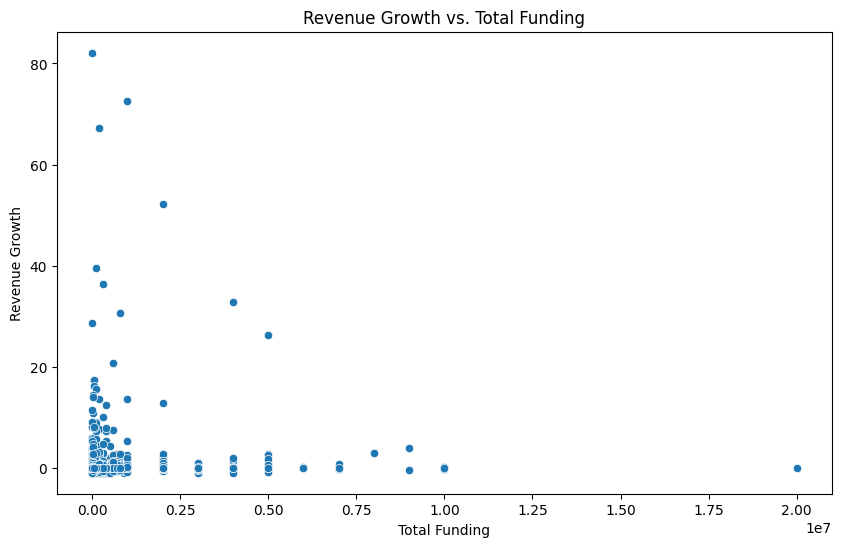

In [145]:
# Example 1: Scatter plot of Revenue Growth vs. Total Funding
# Revenue growth vs. Funding: Examine the relationship between revenue growth and the total funding a company has received. This can help identify efficient startups that achieve high growth with minimal funding.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_for_analytic, x='Total Funding Till Date', y='Revenue growth compared to last FY')
plt.xlabel('Total Funding')
plt.ylabel('Revenue Growth')
plt.title('Revenue Growth vs. Total Funding')
plt.show()

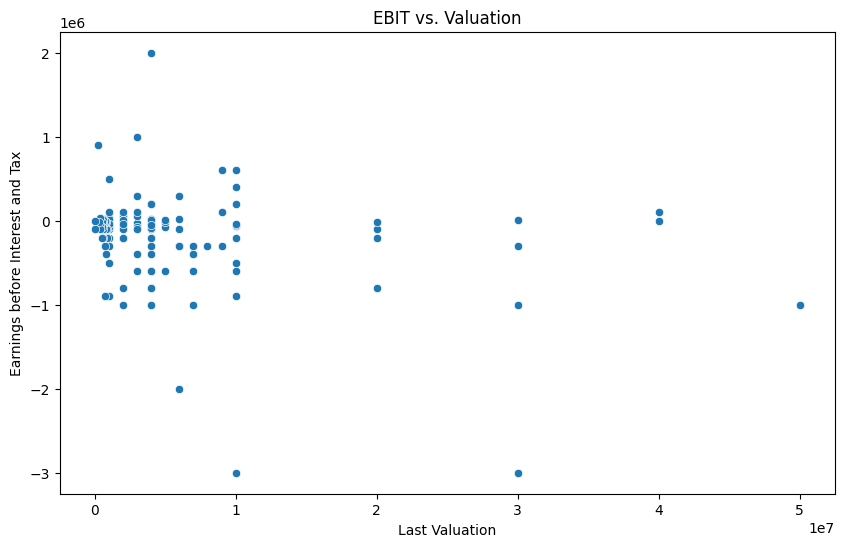

In [146]:
# EBIT vs. Valuation: Analyzing the EBIT (earnings before interest and tax) in relation to the company's valuation can help you identify undervalued or overvalued companies.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Last Valuation', y='Earnings before Interest and Tax', data=df_for_analytic)
plt.title('EBIT vs. Valuation')
plt.show()

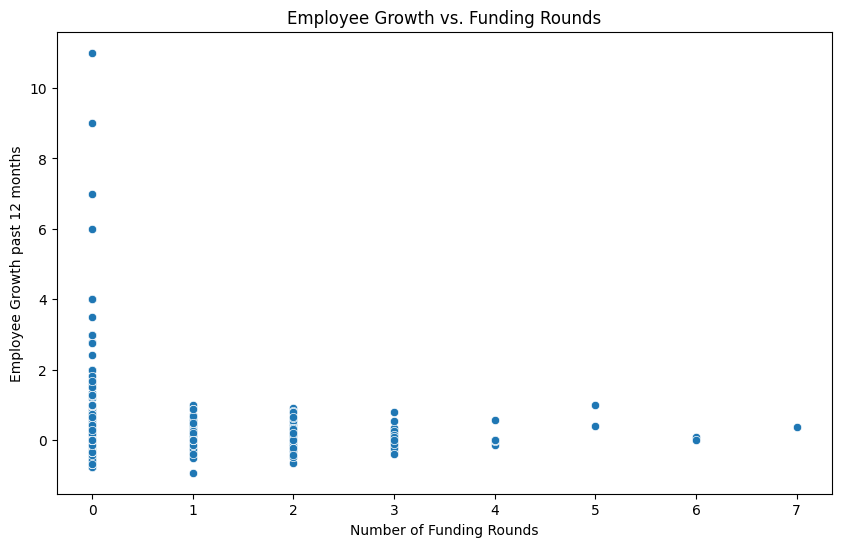

In [148]:
# Employee growth vs. Funding rounds: Investigate the correlation between employee growth and the number of funding rounds a company has gone through. This can help assess how well a startup is scaling its team as it raises funds.
# 3. Employee growth vs. Funding rounds
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Funding Rounds', y='Employee Growth past 12 months', data=df)
plt.title('Employee Growth vs. Funding Rounds')
plt.show()

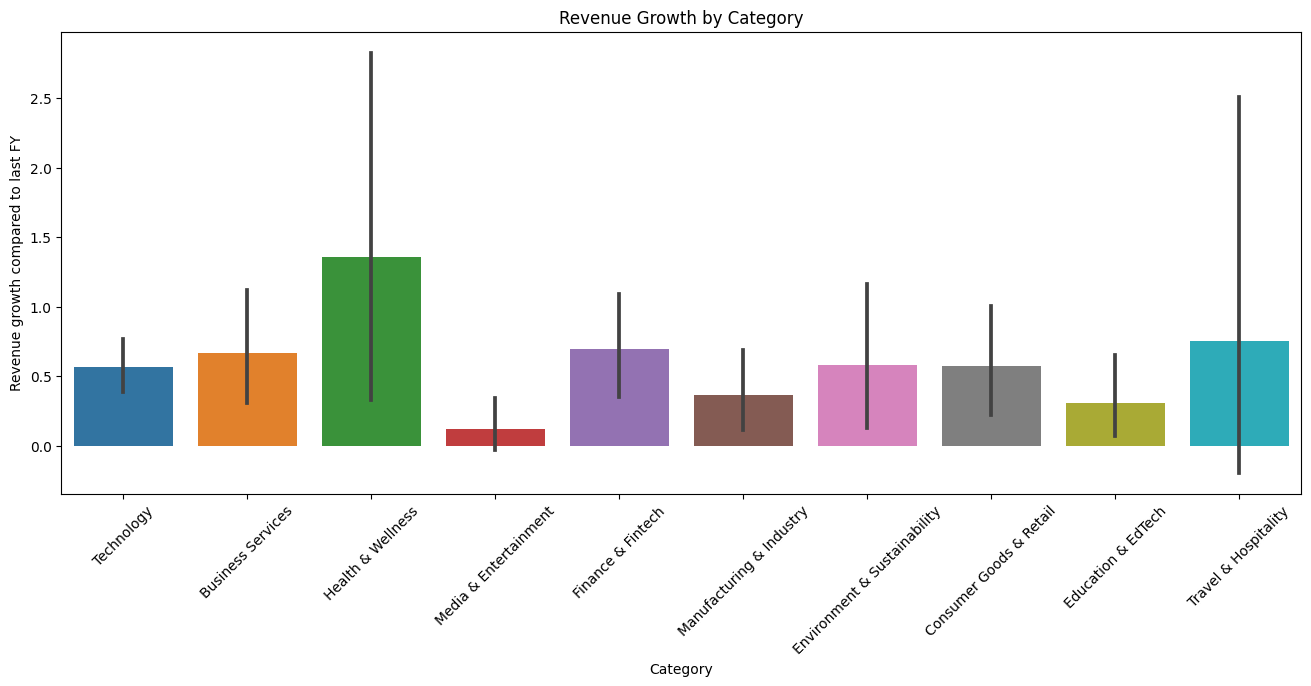

In [185]:
categories = ['Technology', 'Business Services', 'Health & Wellness', 
              'Media & Entertainment', 'Finance & Fintech', 'Manufacturing & Industry', 
              'Environment & Sustainability', 'Consumer Goods & Retail', 
              'Education & EdTech', 'Travel & Hospitality']

columns_to_analyze = categories + ['Revenue growth compared to last FY']
df_for_analytic_filtered = df_for_analytic[columns_to_analyze]
df_melted = df_for_analytic_filtered.melt(id_vars='Revenue growth compared to last FY', value_vars=categories, var_name='Category', value_name='Value')
df_melted = df_melted[df_melted['Value'] == 1]
plt.figure(figsize=(16, 6))
sns.barplot(x='Category', y='Revenue growth compared to last FY', data=df_melted)
plt.title('Revenue Growth by Category')
plt.xticks(rotation=45)
plt.show()

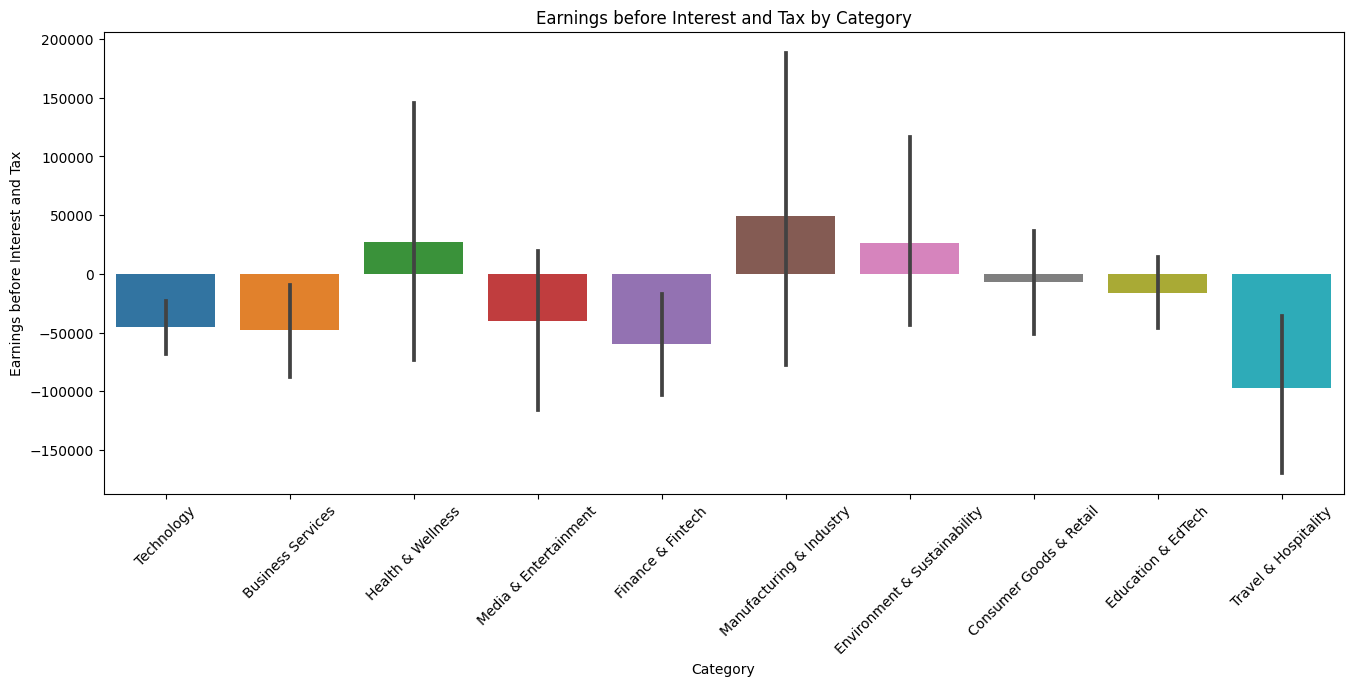

In [188]:
['Name of Startup', 'Incorporation Date', 'Total Funding Till Date',
    'Last Valuation', 'Amt raised during last funding round',
    'Revenue for latest Financial Year', 'Date of last fund raise',
    'Date of Financial Year End', 'Revenue growth compared to last FY',
    'Earnings before Interest and Tax', 'Employee Growth past 6 months',
    'Employee Growth past 12 months', 'Num of Founders',
    'Number of Funding Rounds', 'Number of Shareholders',
    'Minimum Share in %', 'Median Share in %', 'Max Share in %',
    'Technology', 'Business Services', 'Health & Wellness',
    'Media & Entertainment', 'Finance & Fintech',
    'Manufacturing & Industry', 'Environment & Sustainability',
    'Consumer Goods & Retail', 'Education & EdTech',
    'Travel & Hospitality', 'Technology', 'Business Services', 'Health & Wellness', 
    'Media & Entertainment', 'Finance & Fintech', 'Manufacturing & Industry', 'Environment & Sustainability', 
    'Consumer Goods & Retail', 'Education & EdTech', 'Travel & Hospitality']

columns_to_analyze = categories + ['Earnings before Interest and Tax']
df_for_analytic_filtered = df_for_analytic[columns_to_analyze]
df_melted = df_for_analytic_filtered.melt(id_vars='Earnings before Interest and Tax', value_vars=categories, var_name='Category', value_name='Value')
df_melted = df_melted[df_melted['Value'] == 1]
plt.figure(figsize=(16, 6))
sns.barplot(x='Category', y='Earnings before Interest and Tax', data=df_melted)
plt.title('Earnings before Interest and Tax by Category')
plt.xticks(rotation=45)
plt.show()

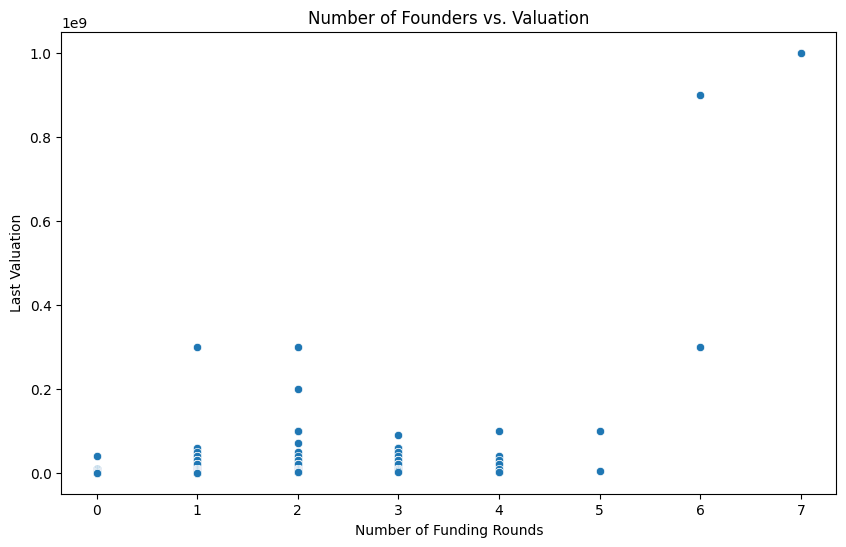

In [189]:
# Founder analysis: Examine the number of founders and their shareholdings in relation to the company's success. This can help identify the impact of founder dynamics on startup performance.

# 5. Founder analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Funding Rounds', y='Last Valuation', data=df)
plt.title('Number of Founders vs. Valuation')
plt.show()

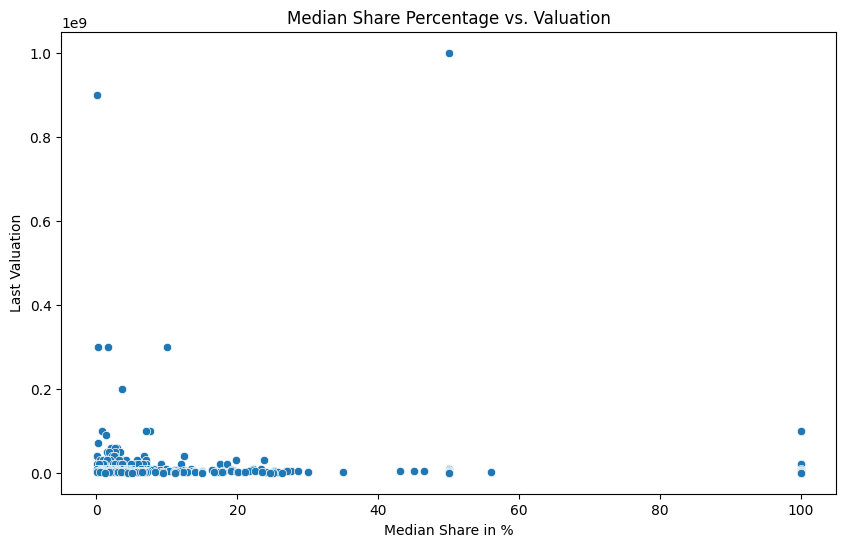

In [192]:
# Shareholder structure: Analyze the shareholder structure (minimum, median, and maximum share percentages) to understand the influence and concentration of ownership in a company.
# 6. Shareholder structure
plt.figure(figsize=(10, 6))
sns.scatterplot(x=r'Median Share in %', y='Last Valuation', data=df)
plt.title('Median Share Percentage vs. Valuation')
plt.show()

In [ ]:
# Time since incorporation: Investigate how long it takes for companies to achieve significant milestones, such as reaching a certain valuation, employee count, or revenue growth. This can help you identify fast-growing startups.
# 7. Time since incorporation
df['Days Since Incorporation'] = (datetime.today() - df['Incorporation Date']).dt.days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Days Since Incorporation', y='Last Valuation', data=df)
plt.title('Days since Incorporation vs. Valuation')
plt.show()

In [ ]:
# Funding round velocity: Calculate the average time between funding rounds to understand how quickly companies are raising funds and their ability to attract investors.
# 8. Funding round velocity
df['Days between rounds'] = df['Date of last fund raise'].diff().dt.days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Days between rounds', y='last valuation', data=df)
plt.title('Days Between Funding Rounds vs. Valuation')
plt.show()

In [ ]:
# Correlation between the latest funding round and the date of the financial year-end: This can help identify if there is any seasonality in funding patterns or if companies tend to raise funds around specific financial events.
# 9. Correlation between the latest funding round and the date of the financial year-end
df['Days from financial year end'] = (df['Date of Financial Year End'] - df['Date of last fund raise']).dt.days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Days from financial year end', y='Amount raised during last funding round', data=df)
plt.title('Days from Financial Year End vs. Amount Raised in the Last Funding Round')
plt.show()